<a href="https://colab.research.google.com/github/Nivashini0710/predictrade/blob/main/recent_stockpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance scikit-learn matplotlib pandas


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-72cc899b13ea>:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  color = 'green' if float(price_i) >= baseline else 'red'


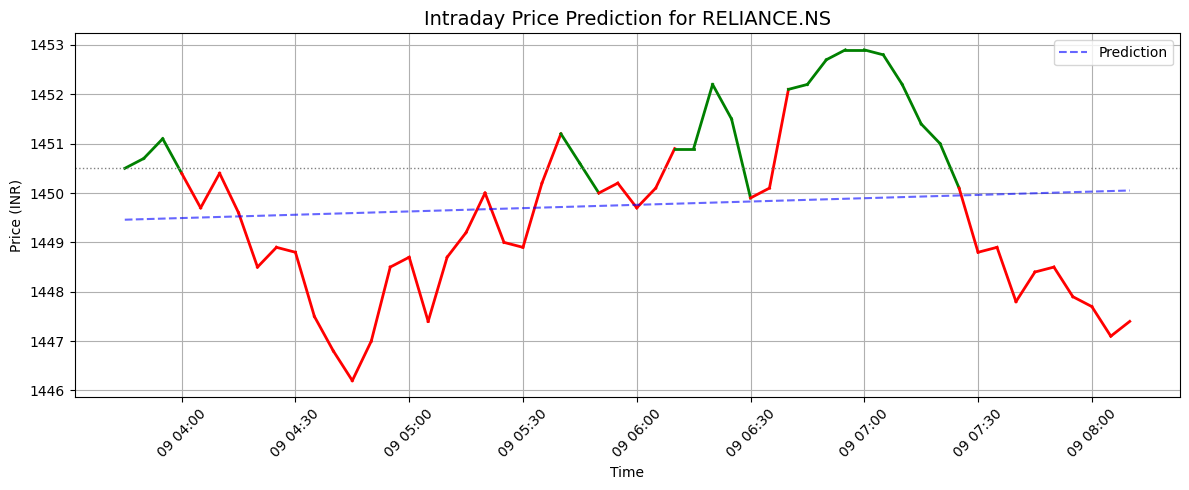

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# ---------- 1. Download Intraday Data ----------
symbol = "RELIANCE.NS"  # Change to your desired NSE symbol
interval = "5m"
period = "1d"

data = yf.download(tickers=symbol, interval=interval, period=period)
if data.empty:
    raise ValueError("No intraday data available. Try during market hours.")

data.reset_index(inplace=True)
data.rename(columns={"Datetime": "Time", "Close": "Price"}, inplace=True)

df = data[["Time", "Price"]].copy()
df["Time"] = pd.to_datetime(df["Time"])
df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ---------- 2. Model Training ----------
X = df[["Minutes"]]
y = df[["Price"]]

model = LinearRegression()
model.fit(X, y.values.ravel())

df["Predicted"] = model.predict(X)

# ---------- 3. Plotting ----------
baseline = float(df["Price"].iloc[0].item())  # Fix the warning

fig, ax = plt.subplots(figsize=(12, 5))
for i in range(len(df) - 1):
    price_i = df['Price'].iloc[i]
    price_i1 = df['Price'].iloc[i + 1]
    color = 'green' if float(price_i) >= baseline else 'red'
    x = [df['Time'].iloc[i], df['Time'].iloc[i + 1]]
    y = [price_i, price_i1]
    ax.plot(x, y, color=color, linewidth=2)

# Add prediction line
ax.plot(df["Time"], df["Predicted"], linestyle='--', label="Prediction", color="blue", alpha=0.6)

# Styling
ax.set_title(f"Intraday Price Prediction for {symbol}", fontsize=14)
ax.set_xlabel("Time")
ax.set_ylabel("Price (INR)")
ax.axhline(baseline, color='gray', linestyle=':', linewidth=1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed

Training model...
Epoch 1/5



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1143
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0025
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0016
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0012
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0012

📈 Highest Predicted Rise Alert:
2025-05-09 03:45:00 | ₹1389.30 ➜ ₹1409.72 ↑ (1.47%)

📉 Lowest Predicted Fall Alert:
2025-05-12 03:50:00 | ₹1423.00 ➜ ₹1381.54 ↓ (-2.91%)


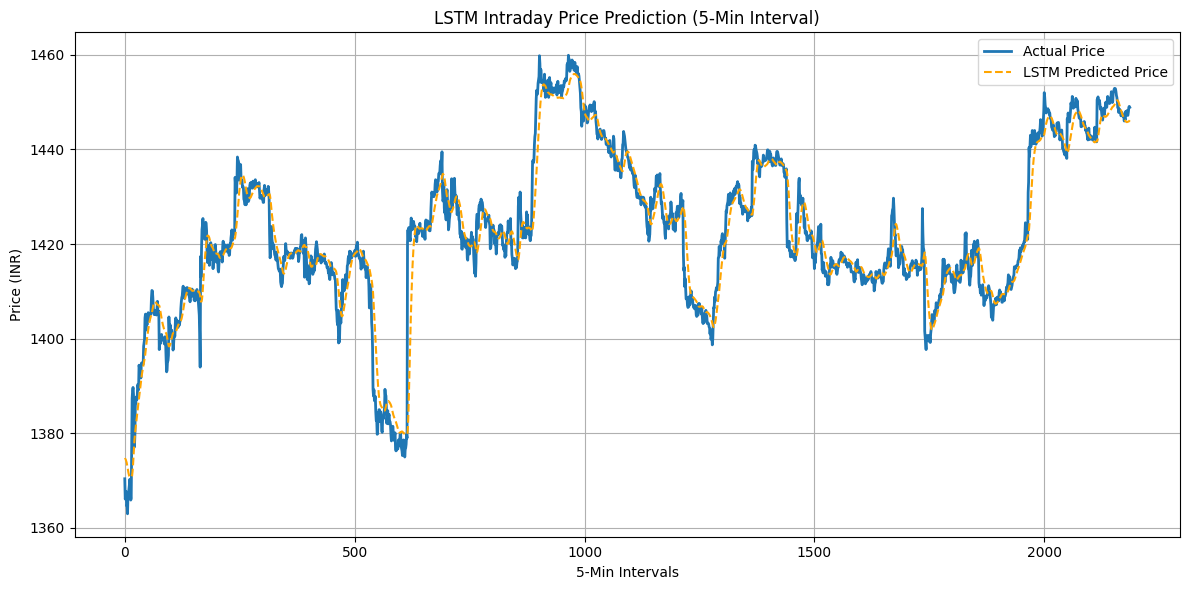

In [11]:
# 📦 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 📌 Step 1: Download 5-min interval data for last 30 trading days
symbol = "RELIANCE.NS"
interval = "5m"
period = "30d"

print("Downloading data...")
df = yf.download(tickers=symbol, interval=interval, period=period)
if df.empty:
    raise ValueError("No data returned. Check if the market is open or symbol is valid.")

df.reset_index(inplace=True)
df = df[['Datetime', 'Close']].rename(columns={'Datetime': 'Time', 'Close': 'Price'})
df['Time'] = pd.to_datetime(df['Time'])

# 📌 Step 2: Preprocess and prepare LSTM input
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['Price']])

window_size = 60  # 60 timestamps (5-minute windows = 5 hours)
X, y = [], []
for i in range(window_size, len(scaled_prices)):
    X.append(scaled_prices[i - window_size:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 📌 Step 3: Build and train LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

print("Training model...")
model.fit(X, y, epochs=5, batch_size=32, verbose=1)

# 📌 Step 4: Real-time prediction simulation + alerts
def simulate_realtime_prediction(df, model, scaler, window_size=60):
    price_list = df['Price'].squeeze().tolist()
    times = df['Time'].squeeze().tolist()

    max_rise = {"time": None, "actual": 0, "predicted": 0, "diff": -float("inf")}
    max_fall = {"time": None, "actual": 0, "predicted": 0, "diff": float("inf")}

    for i in range(window_size, len(price_list)):
        past_window = price_list[i - window_size:i]
        scaled_input = scaler.transform(np.array(past_window).reshape(-1, 1))
        x_input = np.reshape(scaled_input, (1, window_size, 1))
        predicted_scaled = model.predict(x_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

        actual = price_list[i]
        timestamp = times[i]
        change = predicted_price - actual

        # Update max rise
        if change > max_rise["diff"]:
            max_rise = {"time": timestamp, "actual": actual, "predicted": predicted_price, "diff": change}

        # Update max fall
        if change < max_fall["diff"]:
            max_fall = {"time": timestamp, "actual": actual, "predicted": predicted_price, "diff": change}

    # 🔔 Display only the highest rise and lowest fall
    print("\n📈 Highest Predicted Rise Alert:")
    print(f"{max_rise['time'].strftime('%Y-%m-%d %H:%M:%S')} | ₹{max_rise['actual']:.2f} ➜ ₹{max_rise['predicted']:.2f} ↑ ({(max_rise['diff']/max_rise['actual'])*100:.2f}%)")

    print("\n📉 Lowest Predicted Fall Alert:")
    print(f"{max_fall['time'].strftime('%Y-%m-%d %H:%M:%S')} | ₹{max_fall['actual']:.2f} ➜ ₹{max_fall['predicted']:.2f} ↓ ({(max_fall['diff']/max_fall['actual'])*100:.2f}%)")

# 📌 Accurate LSTM Prediction Plotting
def plot_predictions(df, model, scaler, window_size=60):
    scaled_prices = scaler.transform(df[['Price']])
    predicted_prices = []

    for i in range(window_size, len(scaled_prices)):
        input_data = scaled_prices[i - window_size:i].reshape(1, window_size, 1)
        pred = model.predict(input_data, verbose=0)
        predicted_prices.append(scaler.inverse_transform(pred)[0][0])

    actual_prices = df['Price'].values[window_size:]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, label='Actual Price', linewidth=2)
    plt.plot(predicted_prices, label='LSTM Predicted Price', linestyle='--', color='orange')
    plt.title("LSTM Intraday Price Prediction (5-Min Interval)")
    plt.xlabel("5-Min Intervals")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🟢 Run simulation + plot
# Final Safe Call
simulate_realtime_prediction(df.copy(), model, scaler)
plot_predictions(df.copy(), model, scaler)




[*********************100%***********************]  1 of 1 completed

Training model...
Epoch 1/5



<ipython-input-10-eb643d37cb31>:31: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  trading_df.drop(columns=['Time_only'], inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.2113
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0291
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0147
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0118
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0109
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

Accuracy on training data:
RMSE: 3.8702
MAE: 2.4240
R² Score: 0.9401

Predicted closing prices per day:
2025-05-30: ₹1420.63
2025-06-02: ₹1413.66
2025-06-03: ₹1405.71
2025-06-04: ₹1423.90
2025-06-05: ₹1443.91
2025-06-06: ₹1444.26


<ipython-input-10-eb643d37cb31>:142: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df.set_index('Time').resample('5T').last().dropna()
<ipython-input-10-eb643d37cb31>:151: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pred_5min = pred_df.resample('5T').last().dropna()


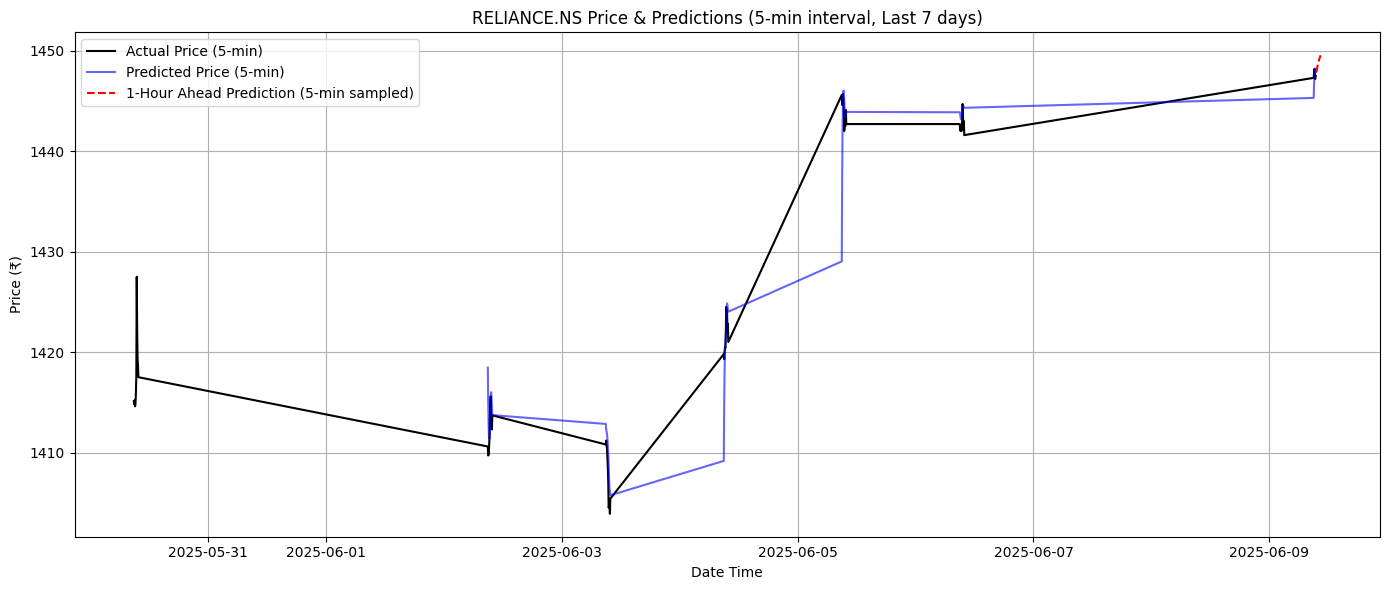

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----- 1. Download 7 days 1-min data -----
symbol = "RELIANCE.NS"
interval = "1m"
period = "7d"

print("Downloading data...")
df = yf.download(tickers=symbol, interval=interval, period=period)
if df.empty:
    raise ValueError("No data downloaded. Try during market hours or check symbol.")

df.reset_index(inplace=True)
df = df.rename(columns={"Datetime": "Time", "Close": "Price"})
df['Time'] = pd.to_datetime(df['Time'])

# ----- 2. Filter data for trading hours 09:00 to 15:30 -----
def filter_trading_hours(df, start_time="09:00:00", end_time="15:30:00"):
    df['Time_only'] = df['Time'].dt.time
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()
    trading_df = df[(df['Time_only'] >= start) & (df['Time_only'] <= end)].copy()
    trading_df.drop(columns=['Time_only'], inplace=True)
    return trading_df

df = filter_trading_hours(df)
if df.empty:
    raise ValueError("No trading hour data after filtering!")

# ----- 3. Prepare data for LSTM -----
prices = df['Price'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

# Create sequences (X) and targets (y)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

# ----- 4. Build and train LSTM model -----
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print("Training model...")
model.fit(X, y, epochs=5, batch_size=32, verbose=1)

# ----- 5. Function to check trading time -----
def is_trading_time(dt, start=time(9,0), end=time(15,30)):
    return start <= dt.time() <= end

# ----- 6. Predict closing price for each trading day -----
def get_daily_closing_predictions(df, model, scaler, seq_length=SEQ_LENGTH, market_close_time="15:30:00"):
    df['Date'] = df['Time'].dt.date
    closing_preds = {}

    for date, group in df.groupby('Date'):
        day_data = group[group['Time'].dt.time <= pd.to_datetime(market_close_time).time()]
        if len(day_data) < seq_length:
            continue
        last_seq = day_data['Price'].values[-seq_length:]
        scaled_seq = scaler.transform(last_seq.reshape(-1,1))
        X_input = scaled_seq.reshape(1, seq_length, 1)

        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        closing_preds[date] = pred_price
    return closing_preds

# ----- 7. Predict 1 hour ahead skipping non-trading hours -----
def predict_1hr_ahead_skip_nontrading(df, model, scaler, seq_length=SEQ_LENGTH, horizon=60):
    last_seq = df['Price'].values[-seq_length:]
    last_time = df['Time'].iloc[-1]

    preds = []
    times = []
    current_seq = last_seq.copy()
    current_time = last_time

    for _ in range(horizon):
        next_time = current_time + timedelta(minutes=1)
        if not is_trading_time(next_time):
            # jump to next trading day 09:00
            next_day = next_time + timedelta(days=1)
            next_time = next_day.replace(hour=9, minute=0, second=0, microsecond=0)

        scaled_seq = scaler.transform(current_seq.reshape(-1,1))
        X_input = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]

        preds.append(pred_price)
        times.append(next_time)

        current_seq = np.append(current_seq[1:], pred_price)
        current_time = next_time

    return pd.DataFrame({'Time': times, 'Predicted_Price': preds})

# ----- 8. Calculate predictions on training data for accuracy -----
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y.reshape(-1,1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nAccuracy on training data:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ----- 9. Generate daily closing predictions -----
daily_closing_preds = get_daily_closing_predictions(df, model, scaler)
print("\nPredicted closing prices per day:")
for date, price in daily_closing_preds.items():
    print(f"{date}: ₹{price:.2f}")

# ----- 10. Generate next 1 hour predictions -----
future_preds = predict_1hr_ahead_skip_nontrading(df, model, scaler)

# ----- 11. Plot actual and predicted prices -----
# Resample actual prices to 5-minute intervals (taking last price in each interval)
df_5min = df.set_index('Time').resample('5T').last().dropna()

# Align predicted and true values with df times and resample to 5-minute intervals
pred_df = pd.DataFrame({
    'Time': df['Time'][SEQ_LENGTH:].values,
    'Predicted': y_pred,
    'Actual': y_true
}).set_index('Time')

pred_5min = pred_df.resample('5T').last().dropna()

# Downsample future predictions by taking every 5th prediction (to get approx 5-min intervals)
future_preds_5min = future_preds.iloc[::5].reset_index(drop=True)

# Plotting
plt.figure(figsize=(14,6))

plt.plot(df_5min.index, df_5min['Price'], label='Actual Price (5-min)', color='black')
plt.plot(pred_5min.index, pred_5min['Predicted'], label='Predicted Price (5-min)', color='blue', alpha=0.6)
plt.plot(future_preds_5min['Time'], future_preds_5min['Predicted_Price'], label='1-Hour Ahead Prediction (5-min sampled)', linestyle='--', color='red')

plt.title(f"{symbol} Price & Predictions (5-min interval, Last 7 days)")
plt.xlabel("Date Time")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed
<ipython-input-14-d542b953b58e>:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  trading_df.drop(columns=['Time_only'], inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1874
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0199
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0148
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0107
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0078
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

Accuracy on training data:
RMSE: 3.9938, MAE: 2.3188, R2 Score: 0.9393


<ipython-input-14-d542b953b58e>:101: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df.set_index('Time').resample('5T').last().dropna()
<ipython-input-14-d542b953b58e>:107: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pred_5min = pred_df.resample('5T').last().dropna()


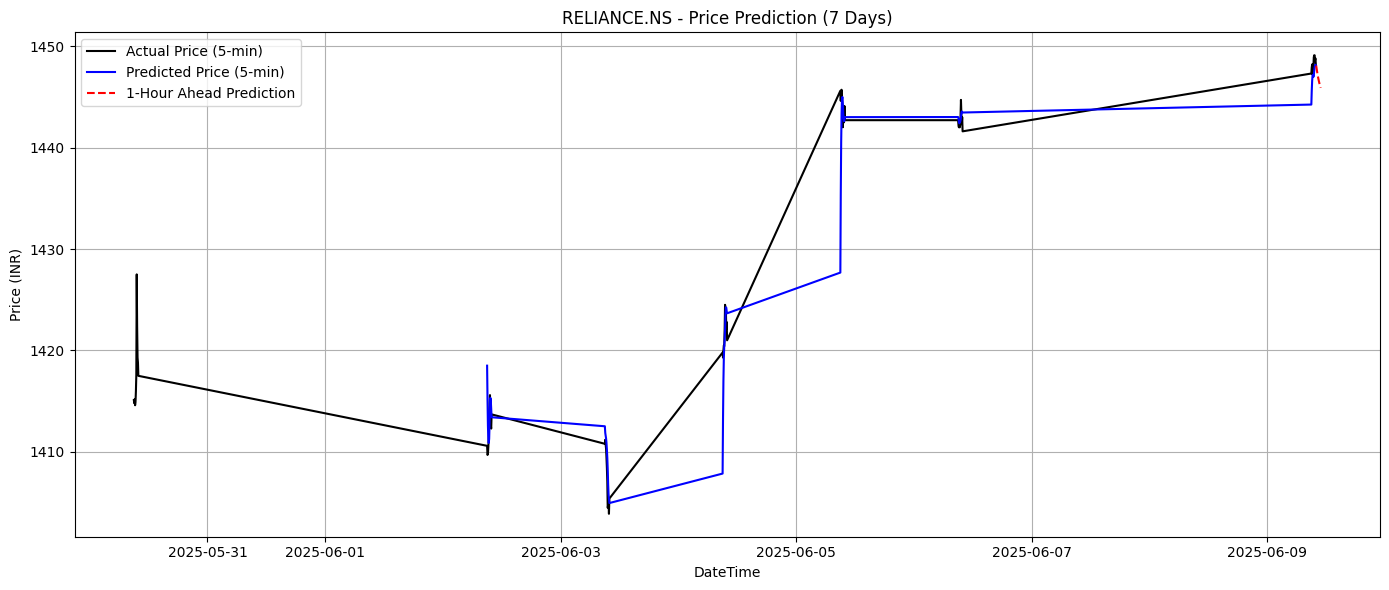


Plotting detailed 1-day wavy prediction...


<ipython-input-14-d542b953b58e>:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  trading_df.drop(columns=['Time_only'], inplace=True)


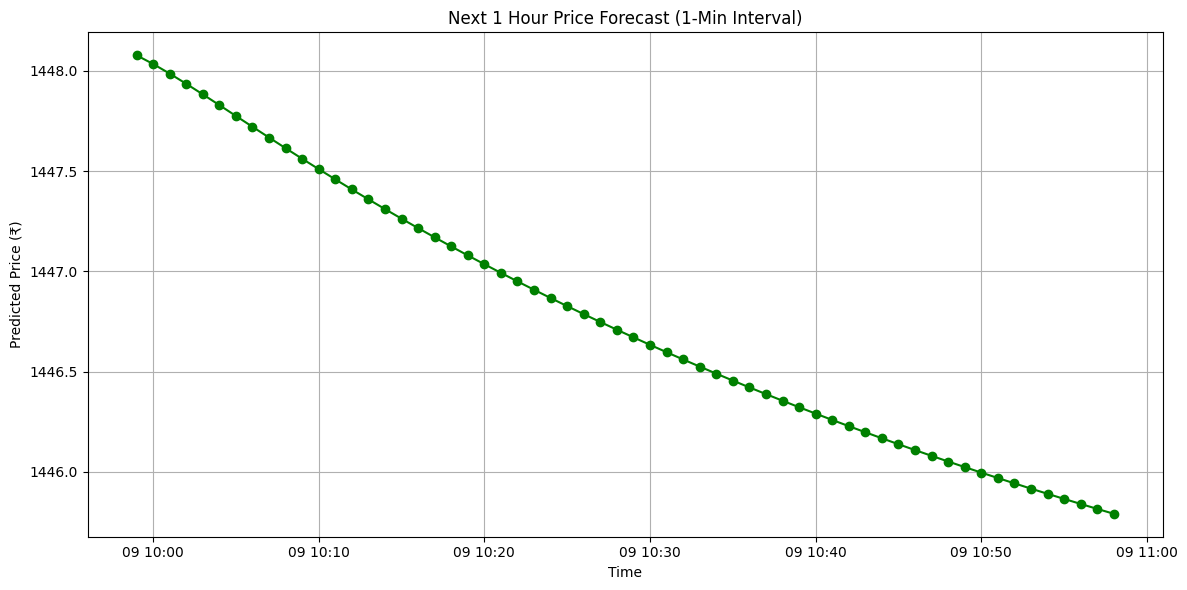


📌 Predicted Closing Price for Next Trading Day (3:30 PM): ₹1444.05


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----- Parameters -----
symbol = "RELIANCE.NS"
interval = "1m"
period = "7d"

print("Downloading data...")
df_full = yf.download(tickers=symbol, interval=interval, period=period)
if df_full.empty:
    raise ValueError("No data downloaded. Try during market hours or check symbol.")

# ----- Preprocess & Filter for Trading Hours -----
def filter_trading_hours(df, start_time="09:00:00", end_time="15:30:00"):
    df.reset_index(inplace=True)
    df = df.rename(columns={"Datetime": "Time", "Close": "Price"})
    df['Time'] = pd.to_datetime(df['Time'])
    df['Time_only'] = df['Time'].dt.time
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()
    trading_df = df[(df['Time_only'] >= start) & (df['Time_only'] <= end)].copy()
    trading_df.drop(columns=['Time_only'], inplace=True)
    return trading_df

df = filter_trading_hours(df_full.copy())

# ----- Prepare for LSTM -----
prices = df['Price'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

SEQ_LENGTH = 60

def create_sequences(data, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices)

# ----- LSTM Model -----
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print("Training model...")
model.fit(X, y, epochs=5, batch_size=32, verbose=1)

# ----- Accuracy -----
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y.reshape(-1,1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nAccuracy on training data:")
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}")

# ----- Plot for 7-day + 1hr future -----
def is_trading_time(dt, start=time(9,0), end=time(15,30)):
    return start <= dt.time() <= end

def predict_1hr_ahead(df, model, scaler, seq_length=SEQ_LENGTH, horizon=60):
    last_seq = df['Price'].values[-seq_length:]
    last_time = df['Time'].iloc[-1]
    preds, times = [], []
    current_seq = last_seq.copy()
    current_time = last_time
    for _ in range(horizon):
        next_time = current_time + timedelta(minutes=1)
        if not is_trading_time(next_time):
            next_day = next_time + timedelta(days=1)
            next_time = next_day.replace(hour=9, minute=0, second=0, microsecond=0)
        scaled_seq = scaler.transform(current_seq.reshape(-1,1))
        X_input = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        preds.append(pred_price)
        times.append(next_time)
        current_seq = np.append(current_seq[1:], pred_price)
        current_time = next_time
    return pd.DataFrame({'Time': times, 'Predicted_Price': preds})

future_preds = predict_1hr_ahead(df, model, scaler)

# ----- Plot full prediction + future -----
df_5min = df.set_index('Time').resample('5T').last().dropna()
pred_df = pd.DataFrame({
    'Time': df['Time'][SEQ_LENGTH:].values,
    'Predicted': y_pred,
    'Actual': y_true
}).set_index('Time')
pred_5min = pred_df.resample('5T').last().dropna()
future_preds_5min = future_preds.iloc[::5].reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.plot(df_5min.index, df_5min['Price'], label='Actual Price (5-min)', color='black')
plt.plot(pred_5min.index, pred_5min['Predicted'], label='Predicted Price (5-min)', color='blue')
plt.plot(future_preds_5min['Time'], future_preds_5min['Predicted_Price'], label='1-Hour Ahead Prediction', linestyle='--', color='red')
plt.title(f"{symbol} - Price Prediction (7 Days)")
plt.xlabel("DateTime")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Accurate LSTM Plot for Single Day -----
print("\nPlotting detailed 1-day wavy prediction...")
df_day = filter_trading_hours(df_full[df_full.index.date == df_full.index[-1].date()].copy())
prices_day = df_day['Price'].values.reshape(-1,1)
scaled_day = scaler.transform(prices_day)

predicted_day = []
for i in range(SEQ_LENGTH, len(scaled_day)):
    seq_input = scaled_day[i-SEQ_LENGTH:i].reshape(1, SEQ_LENGTH, 1)
    pred = model.predict(seq_input, verbose=0)
    predicted_day.append(scaler.inverse_transform(pred)[0][0])

actual_day = df_day['Price'].values[SEQ_LENGTH:]

# -----  12. Plot 1-Hour Future Prediction (Wavy Minute-wise) -----
plt.figure(figsize=(12, 6))
plt.plot(future_preds['Time'], future_preds['Predicted_Price'], marker='o', linestyle='-', color='green')
plt.title("Next 1 Hour Price Forecast (1-Min Interval)")
plt.xlabel("Time")
plt.ylabel("Predicted Price (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----  13. Predict Next Trading Day Closing Price -----
def predict_next_day_close(df, model, scaler, seq_length=SEQ_LENGTH):
    # Assume we want to predict at 3:30 PM tomorrow (next trading day)
    last_seq = df['Price'].values[-seq_length:]
    current_seq = last_seq.copy()
    current_time = df['Time'].iloc[-1]

    # Jump to next trading day's 09:00 AM
    next_day = current_time + timedelta(days=1)
    next_time = next_day.replace(hour=9, minute=0, second=0, microsecond=0)

    predicted_prices = []

    while next_time.time() <= time(15, 30):
        # Predict
        scaled_seq = scaler.transform(current_seq.reshape(-1, 1))
        input_data = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(input_data, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]

        predicted_prices.append((next_time, pred_price))

        # Update sequence and time
        current_seq = np.append(current_seq[1:], pred_price)
        next_time += timedelta(minutes=1)

    return predicted_prices[-1][1] if predicted_prices else None

next_day_close = predict_next_day_close(df, model, scaler)
if next_day_close:
    print(f"\n📌 Predicted Closing Price for Next Trading Day (3:30 PM): ₹{next_day_close:.2f}")
else:
    print("\n❗ Unable to predict next day closing price (insufficient data).")



[*********************100%***********************]  1 of 1 completed

Training model...
Epoch 1/5



<ipython-input-19-69ac84e32c0c>:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  trading_df.drop(columns=['Time_only'], inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.1998
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0174
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0103
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0068
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0059
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

📊 Accuracy on training data:
RMSE: 0.5264
MAE: 0.3738
R² Score: 0.9382

📅 Predicted closing prices per trading day:
2025-05-30: ₹418.48
2025-06-02: ₹419.37
2025-06-03: ₹417.16
2025-06-04: ₹416.73
2025-06-05: ₹419.71
2025-06-06: ₹421.28
2025-06-09: ₹423.45


<ipython-input-19-69ac84e32c0c>:126: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df.set_index('Time').resample('5T').last().dropna()
<ipython-input-19-69ac84e32c0c>:132: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pred_5min = pred_df.resample('5T').last().dropna()


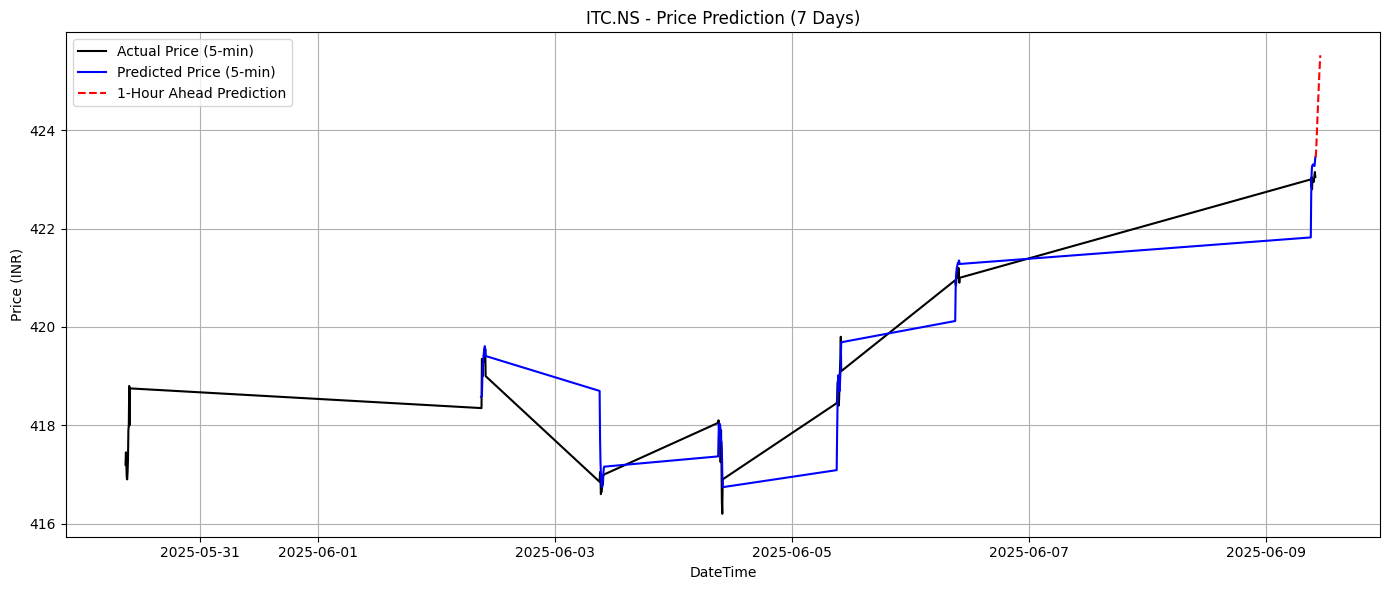


📈 Plotting Next Trading Day (5-min interval) Prediction...


<ipython-input-19-69ac84e32c0c>:177: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_future.set_index('Time').resample('5T').last().dropna().reset_index()


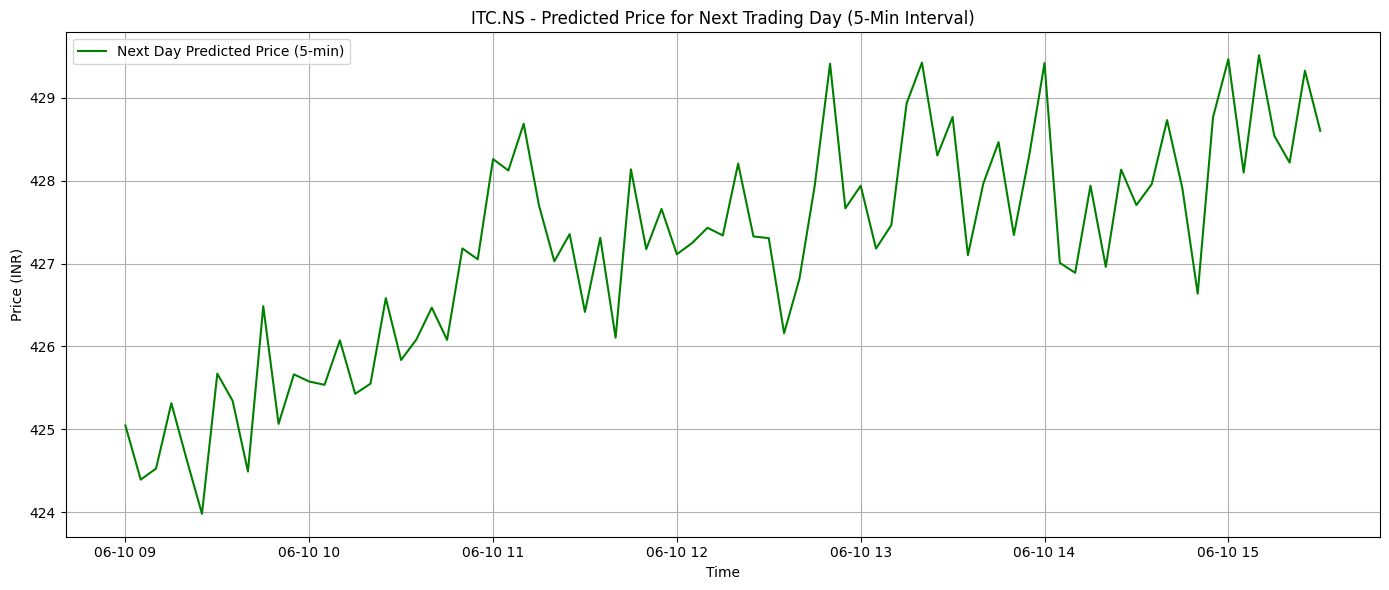


📌 Predicted Closing Price for Next Trading Day (3:30 PM): ₹427.23


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ----- Parameters -----
symbol = "ITC.NS"
interval = "1m"
period = "7d"

print("Downloading data...")
df_full = yf.download(tickers=symbol, interval=interval, period=period)
if df_full.empty:
    raise ValueError("No data downloaded. Try during market hours or check symbol.")

# ----- Preprocess & Filter for Trading Hours -----
def filter_trading_hours(df, start_time="09:00:00", end_time="15:30:00"):
    df.reset_index(inplace=True)
    df = df.rename(columns={"Datetime": "Time", "Close": "Price"})
    df['Time'] = pd.to_datetime(df['Time'])
    df['Time_only'] = df['Time'].dt.time
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()
    trading_df = df[(df['Time_only'] >= start) & (df['Time_only'] <= end)].copy()
    trading_df.drop(columns=['Time_only'], inplace=True)
    return trading_df

df = filter_trading_hours(df_full.copy())

# ----- Prepare for LSTM -----
prices = df['Price'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

SEQ_LENGTH = 60

def create_sequences(data, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices)

# ----- LSTM Model -----
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print("Training model...")
model.fit(X, y, epochs=5, batch_size=32, verbose=1)

# ----- Accuracy -----
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y.reshape(-1,1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📊 Accuracy on training data:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ----- Predicted closing prices per day -----
def get_daily_closing_predictions(df, model, scaler, seq_length=SEQ_LENGTH, market_close_time="15:30:00"):
    df['Date'] = df['Time'].dt.date
    closing_preds = {}

    for date, group in df.groupby('Date'):
        day_data = group[group['Time'].dt.time <= pd.to_datetime(market_close_time).time()]
        if len(day_data) < seq_length:
            continue
        last_seq = day_data['Price'].values[-seq_length:]
        scaled_seq = scaler.transform(last_seq.reshape(-1, 1))
        X_input = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        closing_preds[date] = pred_price
    return closing_preds

daily_closing_preds = get_daily_closing_predictions(df, model, scaler)

print("\n📅 Predicted closing prices per trading day:")
for date, price in daily_closing_preds.items():
    print(f"{date}: ₹{price:.2f}")

# ----- Plot for 7-day + 1hr future -----
def is_trading_time(dt, start=time(9,0), end=time(15,30)):
    return start <= dt.time() <= end

def predict_1hr_ahead(df, model, scaler, seq_length=SEQ_LENGTH, horizon=60):
    last_seq = df['Price'].values[-seq_length:]
    last_time = df['Time'].iloc[-1]
    preds, times = [], []
    current_seq = last_seq.copy()
    current_time = last_time
    for _ in range(horizon):
        next_time = current_time + timedelta(minutes=1)
        if not is_trading_time(next_time):
            next_day = next_time + timedelta(days=1)
            next_time = next_day.replace(hour=9, minute=0, second=0, microsecond=0)
        scaled_seq = scaler.transform(current_seq.reshape(-1,1))
        X_input = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        preds.append(pred_price)
        times.append(next_time)
        current_seq = np.append(current_seq[1:], pred_price)
        current_time = next_time
    return pd.DataFrame({'Time': times, 'Predicted_Price': preds})

future_preds = predict_1hr_ahead(df, model, scaler)

# ----- Plot full prediction + future -----
df_5min = df.set_index('Time').resample('5T').last().dropna()
pred_df = pd.DataFrame({
    'Time': df['Time'][SEQ_LENGTH:].values,
    'Predicted': y_pred,
    'Actual': y_true
}).set_index('Time')
pred_5min = pred_df.resample('5T').last().dropna()
future_preds_5min = future_preds.iloc[::5].reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.plot(df_5min.index, df_5min['Price'], label='Actual Price (5-min)', color='black')
plt.plot(pred_5min.index, pred_5min['Predicted'], label='Predicted Price (5-min)', color='blue')
plt.plot(future_preds_5min['Time'], future_preds_5min['Predicted_Price'], label='1-Hour Ahead Prediction', linestyle='--', color='red')
plt.title(f"{symbol} - Price Prediction (7 Days)")
plt.xlabel("DateTime")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Predict Next Trading Day Full 5-Min Chart -----
def predict_next_day_full(df, model, scaler, seq_length=SEQ_LENGTH):
    last_seq = df['Price'].values[-seq_length:]
    current_seq = last_seq.copy()
    current_time = df['Time'].iloc[-1]

    # Start at 9:00 AM next day
    next_day = current_time + timedelta(days=1)
    current_time = next_day.replace(hour=9, minute=0, second=0, microsecond=0)

    end_time = current_time.replace(hour=15, minute=30)
    predicted_times = []
    predicted_prices = []

    while current_time <= end_time:
        scaled_seq = scaler.transform(current_seq.reshape(-1, 1))
        input_data = scaled_seq.reshape(1, seq_length, 1)
        pred_scaled = model.predict(input_data, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]
        # Add after predicting next day's price
        volatility = 0.002  # Adjust for realism
        pred_price += np.random.normal(0, pred_price * volatility)

        predicted_prices.append(pred_price)
        predicted_times.append(current_time)

        current_seq = np.append(current_seq[1:], pred_price)
        current_time += timedelta(minutes=1)

    df_future = pd.DataFrame({'Time': predicted_times, 'Predicted_Price': predicted_prices})
    df_5min = df_future.set_index('Time').resample('5T').last().dropna().reset_index()
    return df_5min

# ----- Plot Next Day Prediction (5-Min Intervals) -----
print("\n📈 Plotting Next Trading Day (5-min interval) Prediction...")
next_day_pred_df = predict_next_day_full(df, model, scaler)

plt.figure(figsize=(14,6))
plt.plot(next_day_pred_df['Time'], next_day_pred_df['Predicted_Price'], label='Next Day Predicted Price (5-min)', color='green')
plt.title(f"{symbol} - Predicted Price for Next Trading Day (5-Min Interval)")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


next_day_close = predict_next_day_close(df, model, scaler)
if next_day_close:
    print(f"\n📌 Predicted Closing Price for Next Trading Day (3:30 PM): ₹{next_day_close:.2f}")
else:
    print("\n❗ Unable to predict next day closing price (insufficient data).")


